In [125]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import  precision_score, recall_score, f1_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.model import Net as Net
from models.FeedForwardNet.model_3 import Net as Net3
from models.FeedForwardNet.model_2 import Net as Net2
from torchvision import models
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau
from utils.EarlyStopping import EarlyStopping
from imblearn.combine import SMOTEENN
import pytorch_warmup as warmup
import matplotlib.pyplot as plt
from IPython.display import Image

In [126]:
df = pd.read_csv('data/raw/dukecathr.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [127]:

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
balance_accuracy_list = []
precision_list = []
recall_list = []

In [128]:
def train_epoch(model, dataloader, criterion, optimizer, lr_scheduler, warmup_scheduler):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for data in tqdm(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        predicted = torch.round(pred)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        # with warmup_scheduler.dampening():
        #       lr_scheduler.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

In [129]:
def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.detach().cpu().numpy())  # Detach the tensor before converting to numpy
            
    test_loss=running_loss/len(dataloader)
    test_accu=100.*correct/total

    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return test_loss, test_accu, balance_acc, precision, recall

In [130]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=25,target ='RCAST'):
    model_path=F'models/FeedForwardNet/saved_models/{target}/best_model.pth'
    model = model.to(device)
    all_learning_rates = []
    num_steps = len(train_dataloader) * num_epochs
    print(len(train_dataloader))
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= 10, T_mult=2)
    #lr_scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau (optimizer,factor=0.3, patience=5)
    warmup_scheduler = warmup.RAdamWarmup(optimizer) #https://arxiv.org/pdf/1910.04209.pdf
    early_stopping = EarlyStopping(patience=30, verbose=True, model_path=model_path, delta=0.001)

    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer, lr_scheduler,warmup_scheduler)
        train_accu.append(accu)
        train_losses.append(train_loss)
        test_loss, test_accu, balance_acc, precision, recall = evaluate_epoch(model, test_dataloader, criterion)
        eval_losses.append(test_loss)
        eval_accu.append(test_accu)
        balance_accuracy_list.append(balance_acc)
        precision_list.append(precision)
        recall_list.append(recall)
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_accu:.3f} | Balance Accuracy: {balance_acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')
        all_learning_rates.append(optimizer.param_groups[0]["lr"])
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')
        lr_scheduler.step()
   
            
         # Print the current learning rate
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        # Save the model if the balanced accuracy is higher than the current best
        # if balance_acc > best_bal_acc:
        #     print(f'Balanced accuracy increased ({best_bal_acc:.6f} --> {balance_acc:.6f}).  Saving model ...')
        #     os.makedirs(os.path.dirname(model_path), exist_ok=True)
        #     torch.save(model.state_dict(), model_path)  # Save the model
        #     best_bal_acc = balance_acc  # Update the best balanced accuracy
    plt.plot(all_learning_rates)
    plt.show()
        

In [131]:
def evaluate_model(model, dataloader, criterion):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(outputs)  # Round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    # Append the metrics to the lists
    balance_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)

    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

In [132]:
def process_target(df, target, model):
   # Step 1: Preprocess the data
   X, y, num_cols, cat_cols = output_selection_prepro(df, target)

   # Split the data into train and test sets
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
   
   Scaler = StandardScaler( )
   X_train = Scaler.fit_transform(X_train)
   X_test = Scaler.transform(X_test)
   
   
   # Convert features and labels to tensors
   X_train_tensor = torch.tensor(X_train.astype(np.float32))
   X_test_tensor = torch.tensor(X_test.astype(np.float32))
   y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)
   y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

   # Convert the data into PyTorch tensors and load them into a DataLoader
   train_data = TensorDataset(X_train_tensor, y_train_tensor)
   test_data = TensorDataset(X_test_tensor, y_test_tensor)
   #save test data
   torch.save(test_data, f'data/processed/{target}/test_data.pth')

   batch_size = 2048
   train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
   test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

   # Define the model, loss function, and optimizer
   model = model
   criterion = nn.BCELoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.998))
   #https://arxiv.org/pdf/1910.04209.pdf

   # Train the model
   train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=150, target=target)

   evaluate_model(model, test_loader, criterion)

Loading data from data/processed/RCAST/imputed_data_RCAST.csv...


No missing values found.
Final X columns: ['RDAYSFROMINDEX', 'RSEQCATHNUM', 'RSUBJID', 'YRCATH_G', 'AGE_G', 'GENDER', 'RACE_G', 'DPCABG', 'DPMI', 'DPPCI', 'HXANGINA', 'HXCEREB', 'HXCHF', 'HXCOPD', 'HXDIAB', 'HXHTN', 'HXHYL', 'HXMI', 'HXSMOKE', 'NUMPRMI', 'DIASBP_R', 'PULSE_R', 'SYSBP_R', 'CBRUITS', 'HEIGHT_R', 'S3', 'WEIGHT_R', 'CREATININE_R', 'HDL_R', 'LDL_R', 'TOTCHOL_R', 'CATHAPPR', 'DIAGCATH', 'INTVCATH', 'CORDOM', 'GRAFTST', 'LVEF_R', 'DAYS2LKA', 'DSCABG', 'DSMI', 'DSPCI', 'DSSTROKE', 'FUPROTCL']
25
Epoch : 1


100%|██████████| 25/25 [00:00<00:00, 31.39it/s]


Train Loss: 0.691 | Train Accuracy: 56.601 | Test Loss: 0.675 | Test Accuracy: 61.433 | Balance Accuracy: 0.503 | Precision: 0.627 | Recall: 0.948
Learning rate: 7.340780506760304e-06
Validation loss decreased (inf --> 0.674776).  Saving model ...
Epoch : 2


100%|██████████| 25/25 [00:00<00:00, 46.55it/s]


Train Loss: 0.622 | Train Accuracy: 65.916 | Test Loss: 0.556 | Test Accuracy: 72.072 | Balance Accuracy: 0.656 | Precision: 0.717 | Recall: 0.914
Learning rate: 0.00029265847744427303
Validation loss decreased (0.674776 --> 0.555739).  Saving model ...
Epoch : 3


100%|██████████| 25/25 [00:00<00:00, 43.57it/s]


Train Loss: 0.558 | Train Accuracy: 71.047 | Test Loss: 0.531 | Test Accuracy: 73.116 | Balance Accuracy: 0.675 | Precision: 0.732 | Recall: 0.898
Learning rate: 0.0002713525491562421
Validation loss decreased (0.555739 --> 0.530812).  Saving model ...
Epoch : 4


100%|██████████| 25/25 [00:00<00:00, 47.09it/s]


Train Loss: 0.543 | Train Accuracy: 71.990 | Test Loss: 0.524 | Test Accuracy: 73.481 | Balance Accuracy: 0.680 | Precision: 0.736 | Recall: 0.898
Learning rate: 0.00023816778784387094
Validation loss decreased (0.530812 --> 0.523528).  Saving model ...
Epoch : 5


100%|██████████| 25/25 [00:00<00:00, 46.18it/s]


Train Loss: 0.535 | Train Accuracy: 72.291 | Test Loss: 0.521 | Test Accuracy: 73.588 | Balance Accuracy: 0.677 | Precision: 0.731 | Recall: 0.914
Learning rate: 0.0001963525491562421
Validation loss decreased (0.523528 --> 0.521060).  Saving model ...
Epoch : 6


100%|██████████| 25/25 [00:00<00:00, 45.85it/s]


Train Loss: 0.530 | Train Accuracy: 72.752 | Test Loss: 0.513 | Test Accuracy: 73.863 | Balance Accuracy: 0.683 | Precision: 0.737 | Recall: 0.904
Learning rate: 0.00015
Validation loss decreased (0.521060 --> 0.513344).  Saving model ...
Epoch : 7


100%|██████████| 25/25 [00:00<00:00, 44.85it/s]


Train Loss: 0.526 | Train Accuracy: 72.927 | Test Loss: 0.514 | Test Accuracy: 74.125 | Balance Accuracy: 0.689 | Precision: 0.742 | Recall: 0.899
Learning rate: 0.0001036474508437579
EarlyStopping counter: 1 out of 30
Epoch : 8


100%|██████████| 25/25 [00:00<00:00, 36.18it/s]


Train Loss: 0.524 | Train Accuracy: 72.913 | Test Loss: 0.518 | Test Accuracy: 74.024 | Balance Accuracy: 0.688 | Precision: 0.741 | Recall: 0.897
Learning rate: 6.183221215612904e-05
EarlyStopping counter: 2 out of 30
Epoch : 9


100%|██████████| 25/25 [00:00<00:00, 35.89it/s]


Train Loss: 0.525 | Train Accuracy: 73.001 | Test Loss: 0.516 | Test Accuracy: 74.161 | Balance Accuracy: 0.689 | Precision: 0.743 | Recall: 0.898
Learning rate: 2.8647450843757897e-05
EarlyStopping counter: 3 out of 30
Epoch : 10


100%|██████████| 25/25 [00:00<00:00, 35.94it/s]


Train Loss: 0.525 | Train Accuracy: 72.917 | Test Loss: 0.514 | Test Accuracy: 74.197 | Balance Accuracy: 0.690 | Precision: 0.743 | Recall: 0.897
Learning rate: 7.34152255572697e-06
EarlyStopping counter: 4 out of 30
Epoch : 11


100%|██████████| 25/25 [00:00<00:00, 35.57it/s]


Train Loss: 0.523 | Train Accuracy: 73.166 | Test Loss: 0.507 | Test Accuracy: 74.478 | Balance Accuracy: 0.696 | Precision: 0.748 | Recall: 0.891
Learning rate: 0.0003
Validation loss decreased (0.513344 --> 0.507307).  Saving model ...
Epoch : 12


100%|██████████| 25/25 [00:00<00:00, 34.24it/s]


Train Loss: 0.517 | Train Accuracy: 73.588 | Test Loss: 0.506 | Test Accuracy: 74.764 | Balance Accuracy: 0.699 | Precision: 0.750 | Recall: 0.894
Learning rate: 0.00029815325108927063
Validation loss decreased (0.507307 --> 0.506099).  Saving model ...
Epoch : 13


100%|██████████| 25/25 [00:00<00:00, 34.78it/s]


Train Loss: 0.514 | Train Accuracy: 73.815 | Test Loss: 0.506 | Test Accuracy: 74.519 | Balance Accuracy: 0.703 | Precision: 0.757 | Recall: 0.873
Learning rate: 0.00029265847744427303
EarlyStopping counter: 1 out of 30
Epoch : 14


100%|██████████| 25/25 [00:00<00:00, 35.08it/s]


Train Loss: 0.511 | Train Accuracy: 74.213 | Test Loss: 0.504 | Test Accuracy: 74.878 | Balance Accuracy: 0.705 | Precision: 0.757 | Recall: 0.880
Learning rate: 0.00028365097862825513
Validation loss decreased (0.506099 --> 0.503668).  Saving model ...
Epoch : 15


100%|██████████| 25/25 [00:00<00:00, 35.48it/s]


Train Loss: 0.507 | Train Accuracy: 74.364 | Test Loss: 0.502 | Test Accuracy: 75.003 | Balance Accuracy: 0.702 | Precision: 0.753 | Recall: 0.893
Learning rate: 0.0002713525491562421
Validation loss decreased (0.503668 --> 0.501742).  Saving model ...
Epoch : 16


100%|██████████| 25/25 [00:00<00:00, 38.50it/s]


Train Loss: 0.505 | Train Accuracy: 74.525 | Test Loss: 0.500 | Test Accuracy: 75.009 | Balance Accuracy: 0.709 | Precision: 0.762 | Recall: 0.872
Learning rate: 0.00025606601717798207
Validation loss decreased (0.501742 --> 0.499543).  Saving model ...
Epoch : 17


100%|██████████| 25/25 [00:00<00:00, 33.52it/s]


Train Loss: 0.502 | Train Accuracy: 74.786 | Test Loss: 0.501 | Test Accuracy: 75.110 | Balance Accuracy: 0.705 | Precision: 0.756 | Recall: 0.888
Learning rate: 0.00023816778784387094
EarlyStopping counter: 1 out of 30
Epoch : 18


100%|██████████| 25/25 [00:00<00:00, 34.66it/s]


Train Loss: 0.500 | Train Accuracy: 74.820 | Test Loss: 0.496 | Test Accuracy: 75.248 | Balance Accuracy: 0.711 | Precision: 0.763 | Recall: 0.876
Learning rate: 0.00021809857496093199
Validation loss decreased (0.499543 --> 0.495917).  Saving model ...
Epoch : 19


100%|██████████| 25/25 [00:00<00:00, 34.54it/s]


Train Loss: 0.499 | Train Accuracy: 74.848 | Test Loss: 0.497 | Test Accuracy: 75.152 | Balance Accuracy: 0.710 | Precision: 0.762 | Recall: 0.877
Learning rate: 0.0001963525491562421
EarlyStopping counter: 1 out of 30
Epoch : 20


100%|██████████| 25/25 [00:00<00:00, 34.45it/s]


Train Loss: 0.497 | Train Accuracy: 74.963 | Test Loss: 0.497 | Test Accuracy: 75.290 | Balance Accuracy: 0.710 | Precision: 0.761 | Recall: 0.882
Learning rate: 0.00017346516975603462
EarlyStopping counter: 2 out of 30
Epoch : 21


100%|██████████| 25/25 [00:00<00:00, 35.20it/s]


Train Loss: 0.497 | Train Accuracy: 75.108 | Test Loss: 0.497 | Test Accuracy: 75.230 | Balance Accuracy: 0.710 | Precision: 0.762 | Recall: 0.878
Learning rate: 0.00015
EarlyStopping counter: 3 out of 30
Epoch : 22


100%|██████████| 25/25 [00:00<00:00, 31.62it/s]


Train Loss: 0.495 | Train Accuracy: 75.244 | Test Loss: 0.497 | Test Accuracy: 75.200 | Balance Accuracy: 0.713 | Precision: 0.766 | Recall: 0.869
Learning rate: 0.0001265348302439654
EarlyStopping counter: 4 out of 30
Epoch : 23


100%|██████████| 25/25 [00:00<00:00, 43.18it/s]


Train Loss: 0.495 | Train Accuracy: 75.047 | Test Loss: 0.498 | Test Accuracy: 75.343 | Balance Accuracy: 0.711 | Precision: 0.762 | Recall: 0.880
Learning rate: 0.0001036474508437579
EarlyStopping counter: 5 out of 30
Epoch : 24


100%|██████████| 25/25 [00:00<00:00, 42.87it/s]


Train Loss: 0.493 | Train Accuracy: 75.091 | Test Loss: 0.494 | Test Accuracy: 75.200 | Balance Accuracy: 0.713 | Precision: 0.766 | Recall: 0.869
Learning rate: 8.190142503906798e-05
Validation loss decreased (0.495917 --> 0.494295).  Saving model ...
Epoch : 25


100%|██████████| 25/25 [00:00<00:00, 43.14it/s]


Train Loss: 0.494 | Train Accuracy: 75.075 | Test Loss: 0.494 | Test Accuracy: 75.200 | Balance Accuracy: 0.711 | Precision: 0.764 | Recall: 0.874
Learning rate: 6.183221215612904e-05
EarlyStopping counter: 1 out of 30
Epoch : 26


100%|██████████| 25/25 [00:00<00:00, 41.43it/s]


Train Loss: 0.493 | Train Accuracy: 75.391 | Test Loss: 0.497 | Test Accuracy: 75.278 | Balance Accuracy: 0.714 | Precision: 0.767 | Recall: 0.869
Learning rate: 4.3933982822017876e-05
EarlyStopping counter: 2 out of 30
Epoch : 27


100%|██████████| 25/25 [00:00<00:00, 34.65it/s]


Train Loss: 0.491 | Train Accuracy: 75.379 | Test Loss: 0.496 | Test Accuracy: 75.194 | Balance Accuracy: 0.711 | Precision: 0.763 | Recall: 0.875
Learning rate: 2.8647450843757897e-05
EarlyStopping counter: 3 out of 30
Epoch : 28


100%|██████████| 25/25 [00:00<00:00, 30.97it/s]


Train Loss: 0.492 | Train Accuracy: 75.359 | Test Loss: 0.495 | Test Accuracy: 75.230 | Balance Accuracy: 0.712 | Precision: 0.764 | Recall: 0.874
Learning rate: 1.634902137174483e-05
EarlyStopping counter: 4 out of 30
Epoch : 29


100%|██████████| 25/25 [00:00<00:00, 35.57it/s]


Train Loss: 0.492 | Train Accuracy: 75.246 | Test Loss: 0.497 | Test Accuracy: 75.224 | Balance Accuracy: 0.712 | Precision: 0.765 | Recall: 0.871
Learning rate: 7.34152255572697e-06
EarlyStopping counter: 5 out of 30
Epoch : 30


100%|██████████| 25/25 [00:00<00:00, 34.55it/s]


Train Loss: 0.493 | Train Accuracy: 75.180 | Test Loss: 0.497 | Test Accuracy: 75.260 | Balance Accuracy: 0.713 | Precision: 0.766 | Recall: 0.870
Learning rate: 1.8467489107293509e-06
EarlyStopping counter: 6 out of 30
Epoch : 31


100%|██████████| 25/25 [00:00<00:00, 31.78it/s]


Train Loss: 0.492 | Train Accuracy: 75.409 | Test Loss: 0.497 | Test Accuracy: 75.325 | Balance Accuracy: 0.715 | Precision: 0.768 | Recall: 0.868
Learning rate: 0.0003
EarlyStopping counter: 7 out of 30
Epoch : 32


100%|██████████| 25/25 [00:00<00:00, 34.46it/s]


Train Loss: 0.491 | Train Accuracy: 75.292 | Test Loss: 0.492 | Test Accuracy: 75.463 | Balance Accuracy: 0.713 | Precision: 0.764 | Recall: 0.879
Learning rate: 0.00029953760005996916
Validation loss decreased (0.494295 --> 0.491652).  Saving model ...
Epoch : 33


100%|██████████| 25/25 [00:00<00:00, 33.13it/s]


Train Loss: 0.490 | Train Accuracy: 75.489 | Test Loss: 0.495 | Test Accuracy: 75.104 | Balance Accuracy: 0.716 | Precision: 0.771 | Recall: 0.857
Learning rate: 0.00029815325108927063
EarlyStopping counter: 1 out of 30
Epoch : 34


100%|██████████| 25/25 [00:00<00:00, 32.19it/s]


Train Loss: 0.488 | Train Accuracy: 75.566 | Test Loss: 0.496 | Test Accuracy: 75.284 | Balance Accuracy: 0.714 | Precision: 0.766 | Recall: 0.870
Learning rate: 0.0002958554880596515
EarlyStopping counter: 2 out of 30
Epoch : 35


100%|██████████| 25/25 [00:00<00:00, 31.83it/s]


Train Loss: 0.486 | Train Accuracy: 75.753 | Test Loss: 0.498 | Test Accuracy: 75.421 | Balance Accuracy: 0.714 | Precision: 0.766 | Recall: 0.874
Learning rate: 0.00029265847744427303
EarlyStopping counter: 3 out of 30
Epoch : 36


100%|██████████| 25/25 [00:00<00:00, 37.21it/s]


Train Loss: 0.487 | Train Accuracy: 75.825 | Test Loss: 0.491 | Test Accuracy: 75.373 | Balance Accuracy: 0.715 | Precision: 0.767 | Recall: 0.870
Learning rate: 0.000288581929876693
EarlyStopping counter: 4 out of 30
Epoch : 37


100%|██████████| 25/25 [00:00<00:00, 38.87it/s]


Train Loss: 0.485 | Train Accuracy: 75.988 | Test Loss: 0.496 | Test Accuracy: 75.242 | Balance Accuracy: 0.714 | Precision: 0.767 | Recall: 0.867
Learning rate: 0.00028365097862825513
EarlyStopping counter: 5 out of 30
Epoch : 38


100%|██████████| 25/25 [00:00<00:00, 35.45it/s]


Train Loss: 0.484 | Train Accuracy: 75.902 | Test Loss: 0.490 | Test Accuracy: 75.451 | Balance Accuracy: 0.714 | Precision: 0.766 | Recall: 0.875
Learning rate: 0.0002778960246531138
Validation loss decreased (0.491652 --> 0.490271).  Saving model ...
Epoch : 39


100%|██████████| 25/25 [00:00<00:00, 34.98it/s]


Train Loss: 0.482 | Train Accuracy: 75.924 | Test Loss: 0.496 | Test Accuracy: 75.510 | Balance Accuracy: 0.712 | Precision: 0.762 | Recall: 0.885
Learning rate: 0.0002713525491562421
EarlyStopping counter: 1 out of 30
Epoch : 40


100%|██████████| 25/25 [00:00<00:00, 33.07it/s]


Train Loss: 0.481 | Train Accuracy: 76.157 | Test Loss: 0.495 | Test Accuracy: 75.481 | Balance Accuracy: 0.719 | Precision: 0.772 | Recall: 0.863
Learning rate: 0.00026406089484000466
EarlyStopping counter: 2 out of 30
Epoch : 41


100%|██████████| 25/25 [00:00<00:00, 30.57it/s]


Train Loss: 0.478 | Train Accuracy: 76.229 | Test Loss: 0.490 | Test Accuracy: 75.469 | Balance Accuracy: 0.715 | Precision: 0.767 | Recall: 0.873
Learning rate: 0.00025606601717798207
EarlyStopping counter: 3 out of 30
Epoch : 42


100%|██████████| 25/25 [00:00<00:00, 35.52it/s]


Train Loss: 0.479 | Train Accuracy: 76.205 | Test Loss: 0.493 | Test Accuracy: 75.379 | Balance Accuracy: 0.720 | Precision: 0.774 | Recall: 0.856
Learning rate: 0.00024741720724952754
EarlyStopping counter: 4 out of 30
Epoch : 43


100%|██████████| 25/25 [00:00<00:00, 34.83it/s]


Train Loss: 0.478 | Train Accuracy: 76.203 | Test Loss: 0.492 | Test Accuracy: 75.266 | Balance Accuracy: 0.717 | Precision: 0.771 | Recall: 0.860
Learning rate: 0.00023816778784387094
EarlyStopping counter: 5 out of 30
Epoch : 44


100%|██████████| 25/25 [00:00<00:00, 31.13it/s]


Train Loss: 0.475 | Train Accuracy: 76.515 | Test Loss: 0.491 | Test Accuracy: 75.218 | Balance Accuracy: 0.716 | Precision: 0.770 | Recall: 0.860
Learning rate: 0.0002283747847073923
EarlyStopping counter: 6 out of 30
Epoch : 45


100%|██████████| 25/25 [00:00<00:00, 44.36it/s]


Train Loss: 0.476 | Train Accuracy: 76.581 | Test Loss: 0.491 | Test Accuracy: 75.087 | Balance Accuracy: 0.719 | Precision: 0.776 | Recall: 0.846
Learning rate: 0.00021809857496093199
EarlyStopping counter: 7 out of 30
Epoch : 46


100%|██████████| 25/25 [00:00<00:00, 43.63it/s]


Train Loss: 0.473 | Train Accuracy: 76.700 | Test Loss: 0.488 | Test Accuracy: 75.319 | Balance Accuracy: 0.714 | Precision: 0.767 | Recall: 0.870
Learning rate: 0.00020740251485476345
Validation loss decreased (0.490271 --> 0.488054).  Saving model ...
Epoch : 47


100%|██████████| 25/25 [00:00<00:00, 43.24it/s]


Train Loss: 0.474 | Train Accuracy: 76.832 | Test Loss: 0.491 | Test Accuracy: 75.421 | Balance Accuracy: 0.717 | Precision: 0.770 | Recall: 0.865
Learning rate: 0.0001963525491562421
EarlyStopping counter: 1 out of 30
Epoch : 48


100%|██████████| 25/25 [00:00<00:00, 31.74it/s]


Train Loss: 0.471 | Train Accuracy: 76.872 | Test Loss: 0.490 | Test Accuracy: 75.445 | Balance Accuracy: 0.717 | Precision: 0.770 | Recall: 0.867
Learning rate: 0.0001850168045783858
EarlyStopping counter: 2 out of 30
Epoch : 49


100%|██████████| 25/25 [00:00<00:00, 34.05it/s]


Train Loss: 0.471 | Train Accuracy: 76.555 | Test Loss: 0.490 | Test Accuracy: 75.343 | Balance Accuracy: 0.717 | Precision: 0.771 | Recall: 0.861
Learning rate: 0.00017346516975603462
EarlyStopping counter: 3 out of 30
Epoch : 50


100%|██████████| 25/25 [00:00<00:00, 31.98it/s]


Train Loss: 0.470 | Train Accuracy: 76.832 | Test Loss: 0.497 | Test Accuracy: 75.260 | Balance Accuracy: 0.716 | Precision: 0.770 | Recall: 0.862
Learning rate: 0.00016176886435917675
EarlyStopping counter: 4 out of 30
Epoch : 51


100%|██████████| 25/25 [00:00<00:00, 34.82it/s]


Train Loss: 0.468 | Train Accuracy: 76.943 | Test Loss: 0.489 | Test Accuracy: 75.307 | Balance Accuracy: 0.715 | Precision: 0.768 | Recall: 0.867
Learning rate: 0.00015
EarlyStopping counter: 5 out of 30
Epoch : 52


100%|██████████| 25/25 [00:00<00:00, 34.09it/s]


Train Loss: 0.467 | Train Accuracy: 77.035 | Test Loss: 0.492 | Test Accuracy: 75.045 | Balance Accuracy: 0.719 | Precision: 0.777 | Recall: 0.843
Learning rate: 0.00013823113564082325
EarlyStopping counter: 6 out of 30
Epoch : 53


100%|██████████| 25/25 [00:00<00:00, 34.43it/s]


Train Loss: 0.465 | Train Accuracy: 77.126 | Test Loss: 0.489 | Test Accuracy: 75.325 | Balance Accuracy: 0.717 | Precision: 0.771 | Recall: 0.861
Learning rate: 0.0001265348302439654
EarlyStopping counter: 7 out of 30
Epoch : 54


100%|██████████| 25/25 [00:00<00:00, 30.75it/s]


Train Loss: 0.466 | Train Accuracy: 76.953 | Test Loss: 0.490 | Test Accuracy: 75.284 | Balance Accuracy: 0.717 | Precision: 0.771 | Recall: 0.861
Learning rate: 0.0001149831954216142
EarlyStopping counter: 8 out of 30
Epoch : 55


100%|██████████| 25/25 [00:00<00:00, 36.07it/s]


Train Loss: 0.466 | Train Accuracy: 77.089 | Test Loss: 0.490 | Test Accuracy: 75.343 | Balance Accuracy: 0.718 | Precision: 0.772 | Recall: 0.860
Learning rate: 0.0001036474508437579
EarlyStopping counter: 9 out of 30
Epoch : 56


100%|██████████| 25/25 [00:00<00:00, 34.45it/s]


Train Loss: 0.465 | Train Accuracy: 77.053 | Test Loss: 0.489 | Test Accuracy: 75.331 | Balance Accuracy: 0.716 | Precision: 0.770 | Recall: 0.864
Learning rate: 9.259748514523653e-05
EarlyStopping counter: 10 out of 30
Epoch : 57


100%|██████████| 25/25 [00:00<00:00, 33.98it/s]


Train Loss: 0.465 | Train Accuracy: 77.031 | Test Loss: 0.493 | Test Accuracy: 75.200 | Balance Accuracy: 0.718 | Precision: 0.773 | Recall: 0.854
Learning rate: 8.190142503906798e-05
EarlyStopping counter: 11 out of 30
Epoch : 58


100%|██████████| 25/25 [00:00<00:00, 32.32it/s]


Train Loss: 0.464 | Train Accuracy: 77.023 | Test Loss: 0.485 | Test Accuracy: 75.325 | Balance Accuracy: 0.716 | Precision: 0.769 | Recall: 0.866
Learning rate: 7.162521529260767e-05
Validation loss decreased (0.488054 --> 0.485116).  Saving model ...
Epoch : 59


100%|██████████| 25/25 [00:00<00:00, 35.50it/s]


Train Loss: 0.462 | Train Accuracy: 77.427 | Test Loss: 0.488 | Test Accuracy: 75.176 | Balance Accuracy: 0.716 | Precision: 0.771 | Recall: 0.858
Learning rate: 6.183221215612904e-05
EarlyStopping counter: 1 out of 30
Epoch : 60


100%|██████████| 25/25 [00:00<00:00, 34.30it/s]


Train Loss: 0.464 | Train Accuracy: 77.166 | Test Loss: 0.492 | Test Accuracy: 75.116 | Balance Accuracy: 0.717 | Precision: 0.772 | Recall: 0.854
Learning rate: 5.2582792750472464e-05
EarlyStopping counter: 2 out of 30
Epoch : 61


100%|██████████| 25/25 [00:00<00:00, 31.19it/s]


Train Loss: 0.462 | Train Accuracy: 77.102 | Test Loss: 0.490 | Test Accuracy: 75.176 | Balance Accuracy: 0.717 | Precision: 0.773 | Recall: 0.855
Learning rate: 4.3933982822017876e-05
EarlyStopping counter: 3 out of 30
Epoch : 62


100%|██████████| 25/25 [00:00<00:00, 34.25it/s]


Train Loss: 0.463 | Train Accuracy: 77.244 | Test Loss: 0.494 | Test Accuracy: 75.140 | Balance Accuracy: 0.718 | Precision: 0.774 | Recall: 0.850
Learning rate: 3.593910515999536e-05
EarlyStopping counter: 4 out of 30
Epoch : 63


100%|██████████| 25/25 [00:00<00:00, 34.06it/s]


Train Loss: 0.462 | Train Accuracy: 77.190 | Test Loss: 0.491 | Test Accuracy: 75.188 | Balance Accuracy: 0.718 | Precision: 0.773 | Recall: 0.854
Learning rate: 2.8647450843757897e-05
EarlyStopping counter: 5 out of 30
Epoch : 64


100%|██████████| 25/25 [00:00<00:00, 34.58it/s]


Train Loss: 0.461 | Train Accuracy: 77.399 | Test Loss: 0.493 | Test Accuracy: 75.188 | Balance Accuracy: 0.717 | Precision: 0.772 | Recall: 0.855
Learning rate: 2.210397534688617e-05
EarlyStopping counter: 6 out of 30
Epoch : 65


100%|██████████| 25/25 [00:00<00:00, 32.67it/s]


Train Loss: 0.462 | Train Accuracy: 77.244 | Test Loss: 0.492 | Test Accuracy: 75.170 | Balance Accuracy: 0.717 | Precision: 0.771 | Recall: 0.857
Learning rate: 1.634902137174483e-05
EarlyStopping counter: 7 out of 30
Epoch : 66


100%|██████████| 25/25 [00:00<00:00, 34.99it/s]


Train Loss: 0.461 | Train Accuracy: 77.309 | Test Loss: 0.491 | Test Accuracy: 75.182 | Balance Accuracy: 0.718 | Precision: 0.773 | Recall: 0.854
Learning rate: 1.1418070123306989e-05
EarlyStopping counter: 8 out of 30
Epoch : 67


100%|██████████| 25/25 [00:00<00:00, 34.83it/s]


Train Loss: 0.460 | Train Accuracy: 77.250 | Test Loss: 0.494 | Test Accuracy: 75.164 | Balance Accuracy: 0.717 | Precision: 0.772 | Recall: 0.855
Learning rate: 7.34152255572697e-06
EarlyStopping counter: 9 out of 30
Epoch : 68


100%|██████████| 25/25 [00:00<00:00, 40.58it/s]


Train Loss: 0.462 | Train Accuracy: 77.329 | Test Loss: 0.493 | Test Accuracy: 75.122 | Balance Accuracy: 0.716 | Precision: 0.771 | Recall: 0.856
Learning rate: 4.144511940348516e-06
EarlyStopping counter: 10 out of 30
Epoch : 69


100%|██████████| 25/25 [00:00<00:00, 44.87it/s]


Train Loss: 0.461 | Train Accuracy: 77.315 | Test Loss: 0.497 | Test Accuracy: 75.206 | Balance Accuracy: 0.718 | Precision: 0.772 | Recall: 0.855
Learning rate: 1.8467489107293509e-06
EarlyStopping counter: 11 out of 30
Epoch : 70


100%|██████████| 25/25 [00:00<00:00, 43.65it/s]


Train Loss: 0.461 | Train Accuracy: 77.415 | Test Loss: 0.493 | Test Accuracy: 75.146 | Balance Accuracy: 0.717 | Precision: 0.772 | Recall: 0.854
Learning rate: 4.623999400308054e-07
EarlyStopping counter: 12 out of 30
Epoch : 71


100%|██████████| 25/25 [00:00<00:00, 34.11it/s]


Train Loss: 0.463 | Train Accuracy: 77.126 | Test Loss: 0.492 | Test Accuracy: 75.128 | Balance Accuracy: 0.714 | Precision: 0.768 | Recall: 0.862
Learning rate: 0.0003
EarlyStopping counter: 13 out of 30
Epoch : 72


100%|██████████| 25/25 [00:00<00:00, 30.76it/s]


Train Loss: 0.465 | Train Accuracy: 77.148 | Test Loss: 0.497 | Test Accuracy: 75.164 | Balance Accuracy: 0.720 | Precision: 0.776 | Recall: 0.847
Learning rate: 0.00029988435543610843
EarlyStopping counter: 14 out of 30
Epoch : 73


100%|██████████| 25/25 [00:00<00:00, 36.17it/s]


Train Loss: 0.463 | Train Accuracy: 77.244 | Test Loss: 0.496 | Test Accuracy: 75.110 | Balance Accuracy: 0.718 | Precision: 0.774 | Recall: 0.849
Learning rate: 0.00029953760005996916
EarlyStopping counter: 15 out of 30
Epoch : 74


100%|██████████| 25/25 [00:00<00:00, 34.98it/s]


Train Loss: 0.461 | Train Accuracy: 77.296 | Test Loss: 0.493 | Test Accuracy: 75.224 | Balance Accuracy: 0.717 | Precision: 0.771 | Recall: 0.859
Learning rate: 0.00029896026854323894
EarlyStopping counter: 16 out of 30
Epoch : 75


100%|██████████| 25/25 [00:00<00:00, 32.25it/s]


Train Loss: 0.461 | Train Accuracy: 77.395 | Test Loss: 0.492 | Test Accuracy: 75.069 | Balance Accuracy: 0.720 | Precision: 0.777 | Recall: 0.844
Learning rate: 0.00029815325108927063
EarlyStopping counter: 17 out of 30
Epoch : 76


100%|██████████| 25/25 [00:00<00:00, 35.08it/s]


Train Loss: 0.461 | Train Accuracy: 77.391 | Test Loss: 0.494 | Test Accuracy: 75.307 | Balance Accuracy: 0.717 | Precision: 0.770 | Recall: 0.862
Learning rate: 0.00029711779206048454
EarlyStopping counter: 18 out of 30
Epoch : 77


100%|██████████| 25/25 [00:00<00:00, 34.10it/s]


Train Loss: 0.459 | Train Accuracy: 77.558 | Test Loss: 0.494 | Test Accuracy: 74.949 | Balance Accuracy: 0.723 | Precision: 0.783 | Recall: 0.829
Learning rate: 0.0002958554880596515
EarlyStopping counter: 19 out of 30
Epoch : 78


100%|██████████| 25/25 [00:00<00:00, 33.73it/s]


Train Loss: 0.459 | Train Accuracy: 77.417 | Test Loss: 0.491 | Test Accuracy: 75.152 | Balance Accuracy: 0.716 | Precision: 0.770 | Recall: 0.859
Learning rate: 0.000294368285468047
EarlyStopping counter: 20 out of 30
Epoch : 79


100%|██████████| 25/25 [00:00<00:00, 33.54it/s]


Train Loss: 0.457 | Train Accuracy: 77.769 | Test Loss: 0.499 | Test Accuracy: 75.254 | Balance Accuracy: 0.718 | Precision: 0.773 | Recall: 0.855
Learning rate: 0.00029265847744427303
EarlyStopping counter: 21 out of 30
Epoch : 80


100%|██████████| 25/25 [00:00<00:00, 35.79it/s]


Train Loss: 0.455 | Train Accuracy: 77.554 | Test Loss: 0.502 | Test Accuracy: 75.051 | Balance Accuracy: 0.720 | Precision: 0.778 | Recall: 0.841
Learning rate: 0.0002907287003883726
EarlyStopping counter: 22 out of 30
Epoch : 81


100%|██████████| 25/25 [00:00<00:00, 38.76it/s]


Train Loss: 0.455 | Train Accuracy: 77.721 | Test Loss: 0.496 | Test Accuracy: 75.272 | Balance Accuracy: 0.720 | Precision: 0.775 | Recall: 0.852
Learning rate: 0.000288581929876693
EarlyStopping counter: 23 out of 30
Epoch : 82


100%|██████████| 25/25 [00:00<00:00, 39.24it/s]


Train Loss: 0.453 | Train Accuracy: 77.918 | Test Loss: 0.492 | Test Accuracy: 75.087 | Balance Accuracy: 0.719 | Precision: 0.776 | Recall: 0.845
Learning rate: 0.0002862214760737622
EarlyStopping counter: 24 out of 30
Epoch : 83


100%|██████████| 25/25 [00:00<00:00, 37.65it/s]


Train Loss: 0.451 | Train Accuracy: 77.982 | Test Loss: 0.496 | Test Accuracy: 75.367 | Balance Accuracy: 0.718 | Precision: 0.772 | Recall: 0.861
Learning rate: 0.00028365097862825513
EarlyStopping counter: 25 out of 30
Epoch : 84


100%|██████████| 25/25 [00:00<00:00, 33.94it/s]


Train Loss: 0.451 | Train Accuracy: 78.042 | Test Loss: 0.497 | Test Accuracy: 75.224 | Balance Accuracy: 0.719 | Precision: 0.775 | Recall: 0.851
Learning rate: 0.0002808744010609196
EarlyStopping counter: 26 out of 30
Epoch : 85


100%|██████████| 25/25 [00:00<00:00, 33.24it/s]


Train Loss: 0.451 | Train Accuracy: 77.849 | Test Loss: 0.494 | Test Accuracy: 75.081 | Balance Accuracy: 0.717 | Precision: 0.772 | Recall: 0.854
Learning rate: 0.0002778960246531138
EarlyStopping counter: 27 out of 30
Epoch : 86


100%|██████████| 25/25 [00:00<00:00, 33.18it/s]


Train Loss: 0.451 | Train Accuracy: 77.976 | Test Loss: 0.494 | Test Accuracy: 74.991 | Balance Accuracy: 0.718 | Precision: 0.774 | Recall: 0.847
Learning rate: 0.0002747204418453818
EarlyStopping counter: 28 out of 30
Epoch : 87


100%|██████████| 25/25 [00:00<00:00, 33.20it/s]


Train Loss: 0.448 | Train Accuracy: 78.183 | Test Loss: 0.497 | Test Accuracy: 75.009 | Balance Accuracy: 0.719 | Precision: 0.777 | Recall: 0.842
Learning rate: 0.0002713525491562421
EarlyStopping counter: 29 out of 30
Epoch : 88


100%|██████████| 25/25 [00:00<00:00, 32.13it/s]


Train Loss: 0.447 | Train Accuracy: 78.127 | Test Loss: 0.491 | Test Accuracy: 75.182 | Balance Accuracy: 0.716 | Precision: 0.771 | Recall: 0.859
Learning rate: 0.0002677975396321117
EarlyStopping counter: 30 out of 30
Early stopping


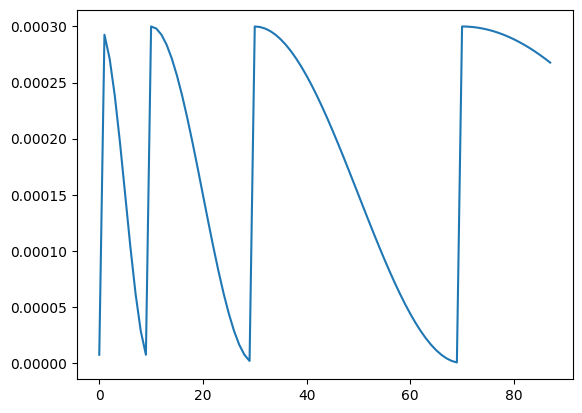

100%|██████████| 9/9 [00:00<00:00, 32.15it/s]


Test Loss: 0.498 | Accuracy: 75.182


In [133]:
process_target(df, 'RCAST', Net3(43))

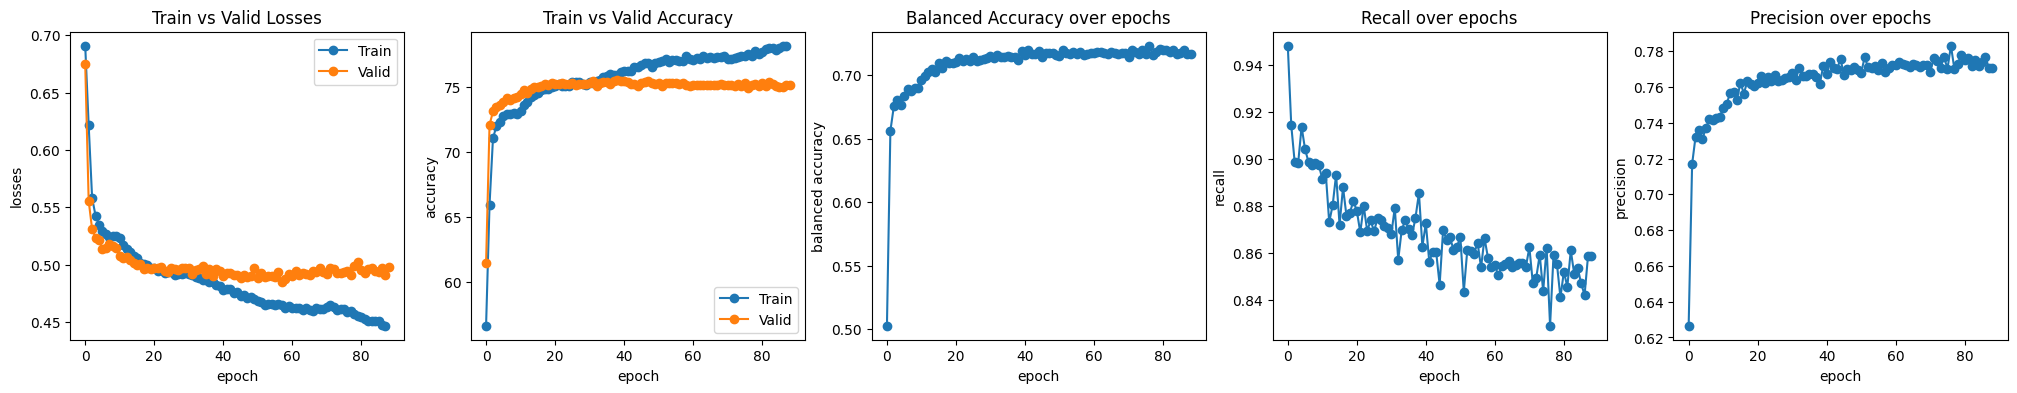

In [134]:
# plot the loss and accuracy and
metrics = {
    'train_losses': train_losses,
    'train_accu': train_accu,
    'eval_losses': eval_losses,
    'eval_accu': eval_accu,
    'balance_accuracy_list': balance_accuracy_list,
    'precision_list': precision_list,
    'recall_list': recall_list
}
plot_metrics(metrics, ['loss', 'accuracy', 'balance_accuracy', 'recall', 'precision'])

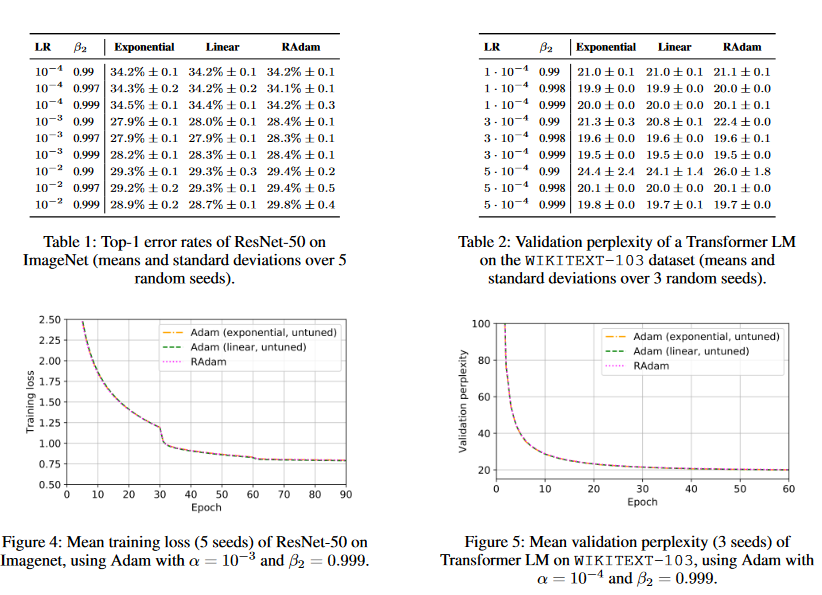

In [135]:

#adaptive learning rate can have high variance in the early stages of training
Image(filename='data\Screenshot 2023-11-01 234812.png')

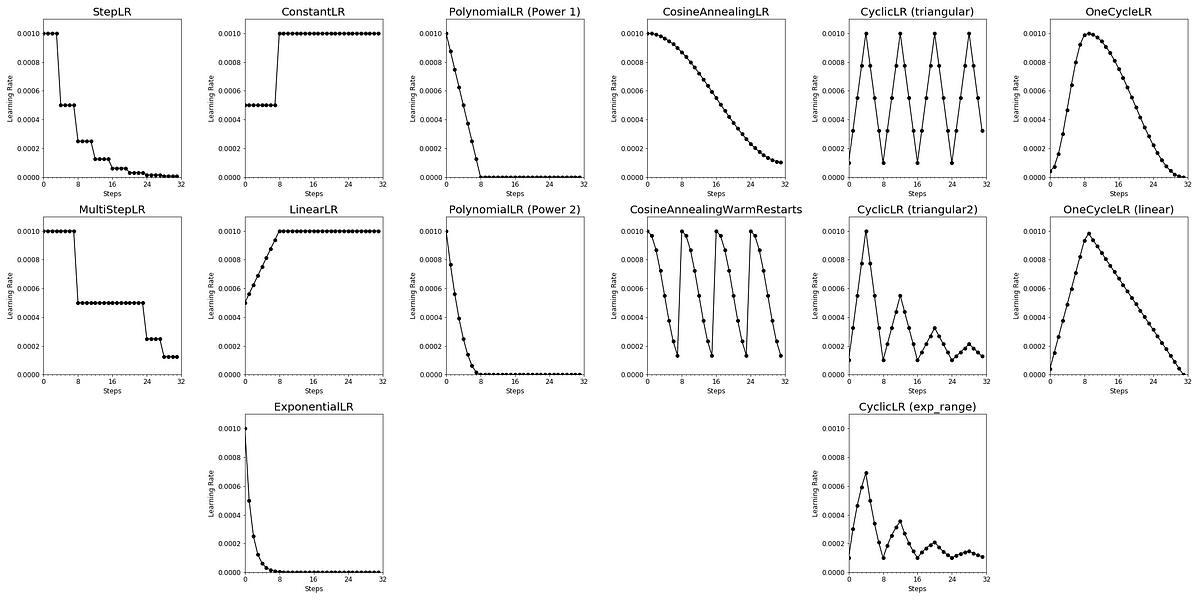

In [136]:
Image(filename='data\qe6nYlH8zsmUdScyHMhRCQ-3509617497.png')

In [137]:
accuracy, precision, recall, balance_accuracy = test_model('RCAST')

In [138]:
print(f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}')

ValueError: Unknown format code 'f' for object of type 'str'